In [241]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressiscaon
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling1D,Conv1D,Conv2D, MaxPooling2D, LSTM, GRU
from keras.optimizers import SGD
from keras.losses import mean_squared_error
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [242]:
# Load audio file paths and labels
data = pd.read_csv('audio.csv')

In [243]:
data

audio_path  label
0        /Users/admin/Documents/thesis/exp_data/ 1.wav      1
1        /Users/admin/Documents/thesis/exp_data/ 2.wav      1
2        /Users/admin/Documents/thesis/exp_data/ 3.wav      1
3        /Users/admin/Documents/thesis/exp_data/ 4.wav      1
4        /Users/admin/Documents/thesis/exp_data/ 5.wav      1
...                                                ...    ...
1524  /Users/admin/Documents/thesis/exp_data/ 1525.wav      1
1525  /Users/admin/Documents/thesis/exp_data/ 1526.wav      1
1526  /Users/admin/Documents/thesis/exp_data/ 1527.wav      1
1527  /Users/admin/Documents/thesis/exp_data/ 1528.wav      1
1528  /Users/admin/Documents/thesis/exp_data/ 1529.wav      1

[1529 rows x 2 columns]

In [244]:
# Function to plot Mel spectrogram
def plot_mel_spectrogram(audio_path):
    # Load audio file
    audio_data, sample_rate = librosa.load(audio_path)
    
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Plot Mel spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

In [245]:
hate_audio = data.loc[0, 'audio_path']
neutral_audio = data.loc[71, 'audio_path']

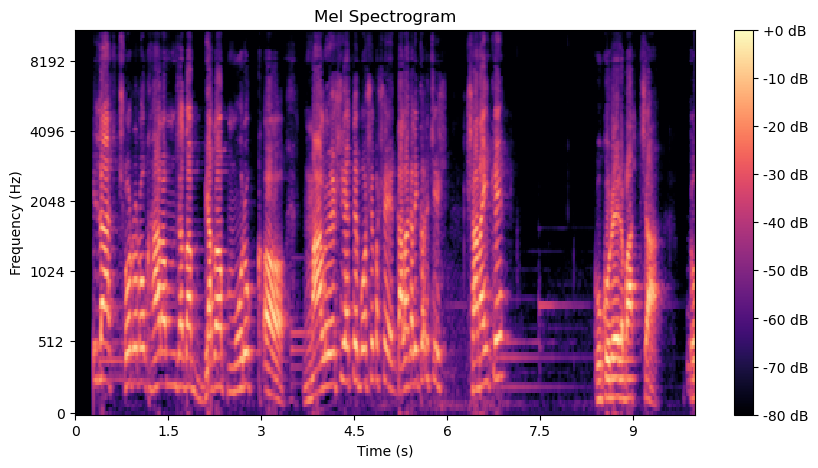

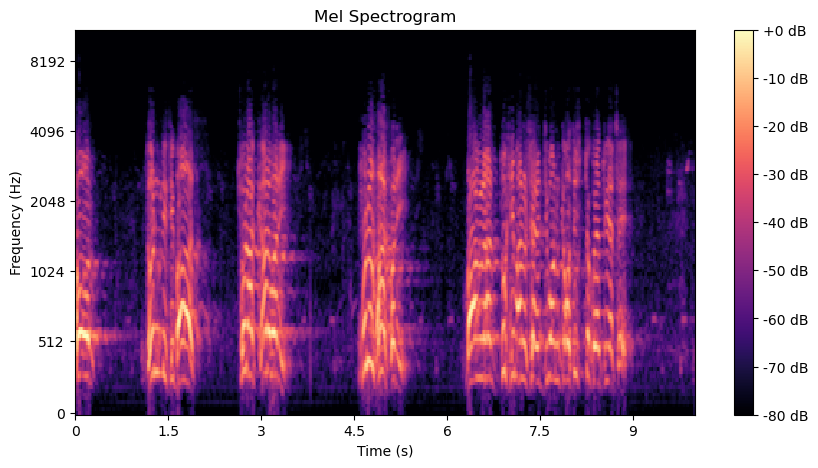

In [246]:
plot_mel_spectrogram(hate_audio)
plot_mel_spectrogram(neutral_audio)

In [247]:
# Function to extract audio features
def extract_mfcc(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Define functions for other audio features
def extract_chroma(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
    chroma_mean = np.mean(chroma.T, axis=0)
    return chroma_mean

def extract_mel(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_mean = np.mean(mel.T, axis=0)
    return mel_mean

def extract_contrast(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
    contrast_mean = np.mean(contrast.T, axis=0)
    return contrast_mean

def extract_rolloff(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)[0]
    return np.mean(rolloff)

def extract_bandwidth(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)[0]
    return np.mean(bandwidth)

def extract_centroid(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)[0]
    return np.mean(centroid)

In [248]:
# Extract features and labels
features = []
labels = []
for index, row in data.iterrows():
    audio_path = row['audio_path']
    label = row['label']
    mfcc = extract_mfcc(audio_path)
    chroma = extract_chroma(audio_path)
    mel = extract_mel(audio_path)
    contrast = extract_contrast(audio_path)
    rolloff = extract_rolloff(audio_path)
    bandwidth = extract_bandwidth(audio_path)
    centroid = extract_centroid(audio_path)
    
    # Concatenate all features
    all_features = np.concatenate([mfcc, chroma, mel, contrast, [rolloff], [bandwidth], [centroid]])
    
    features.append(all_features)
    labels.append(label)

In [249]:
features

[array([-2.07810272e+02,  1.03077065e+02, -2.16372986e+01,  1.63196528e+00,
        -2.69848289e+01, -1.05868196e+01, -1.10818405e+01, -6.31985235e+00,
        -3.08447719e+00, -6.55381584e+00, -3.38701868e+00, -2.49674782e-01,
        -7.98667097e+00, -4.44588304e-01, -1.74376786e+00,  1.08953154e+00,
        -3.70273924e+00,  1.71686065e+00, -6.57885790e+00, -3.40794730e+00,
        -8.14524269e+00, -2.68246746e+00, -5.30675030e+00, -4.62408924e+00,
         2.25606084e-01, -3.74433565e+00,  1.25862849e+00,  5.96189678e-01,
         1.85518813e+00,  1.53586352e+00,  2.84527421e+00,  2.92285895e+00,
         4.39443016e+00,  4.36070919e+00,  1.89352453e+00,  2.18719220e+00,
        -1.39364982e+00,  7.93348014e-01, -1.55564237e+00,  5.88992953e-01,
         2.91441888e-01,  2.44182006e-01,  2.07961097e-01,  2.26082861e-01,
         2.40075469e-01,  2.30224028e-01,  2.87806869e-01,  4.22217518e-01,
         3.75289738e-01,  3.59674394e-01,  3.37623894e-01,  2.80543327e-01,
         1.1

In [250]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [251]:
# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

In [252]:
# Split dataset into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)  # 0.25 x 0.8 = 0.2

In [253]:
# Define parameter grids for each model
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
rf_param_grid = {'n_estimators': [100, 200, 300],'max_depth': [None, 10, 20, 30]}
knn_param_grid = {'n_neighbors': [3, 5, 7]}
lr_param_grid = {'C': [0.1, 1, 10]}


In [254]:
# Perform grid search for each model
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5)
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5)
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5)


In [255]:
# Fit grid search models
svm_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)
knn_grid_search.fit(X_train, y_train)
lr_grid_search.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10]})

In [256]:
# Print best hyperparameters for each model
print("Best hyperparameters for SVM:", svm_grid_search.best_params_)
print("Best hyperparameters for Random Forest:", rf_grid_search.best_params_)
print("Best hyperparameters for KNN:", knn_grid_search.best_params_)
print("Best hyperparameters for Logistic Regression:", lr_grid_search.best_params_)

Best hyperparameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best hyperparameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best hyperparameters for KNN: {'n_neighbors': 5}
Best hyperparameters for Logistic Regression: {'C': 10}


In [257]:
# Evaluate models with best hyperparameters on validation set
svm_val_pred = svm_grid_search.predict(X_val)
rf_val_pred = rf_grid_search.predict(X_val)
knn_val_pred = knn_grid_search.predict(X_val)
lr_val_pred = lr_grid_search.predict(X_val)

# Print classification reports for models with best hyperparameters
print("\nClassification Report for SVM:")
print(classification_report(y_val, svm_val_pred))

print("\nClassification Report for Random Forest:")
print(classification_report(y_val, rf_val_pred))

print("\nClassification Report for KNN:")
print(classification_report(y_val, knn_val_pred))

print("\nClassification Report for LR:")
print(classification_report(y_val, lr_val_pred))




Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        58
           1       0.95      0.98      0.97       248

    accuracy                           0.94       306
   macro avg       0.93      0.88      0.90       306
weighted avg       0.94      0.94      0.94       306


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        58
           1       0.94      1.00      0.97       248

    accuracy                           0.95       306
   macro avg       0.97      0.86      0.90       306
weighted avg       0.95      0.95      0.94       306


Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        58
           1       0.94      0.94      0.94       248

    accuracy                           0.90       306
   macro avg       0.8

In [258]:
# Calculate scores for each model
svm_scores = classification_report(y_val, svm_val_pred, output_dict=True)
rf_scores = classification_report(y_val, rf_val_pred, output_dict=True)
knn_scores = classification_report(y_val, knn_val_pred, output_dict=True)
lr_scores = classification_report(y_val, lr_val_pred, output_dict=True)


In [259]:
# Extract accuracy scores
accuracy_scores = {
    'SVM': svm_scores['accuracy'],
    'Random Forest': rf_scores['accuracy'],
    'KNN': knn_scores['accuracy'],
    'Logistic Regression': lr_scores['accuracy']
}

In [260]:
accuracy_scores

{'SVM': 0.9444444444444444,
 'Random Forest': 0.9477124183006536,
 'KNN': 0.9019607843137255,
 'Logistic Regression': 0.8823529411764706}

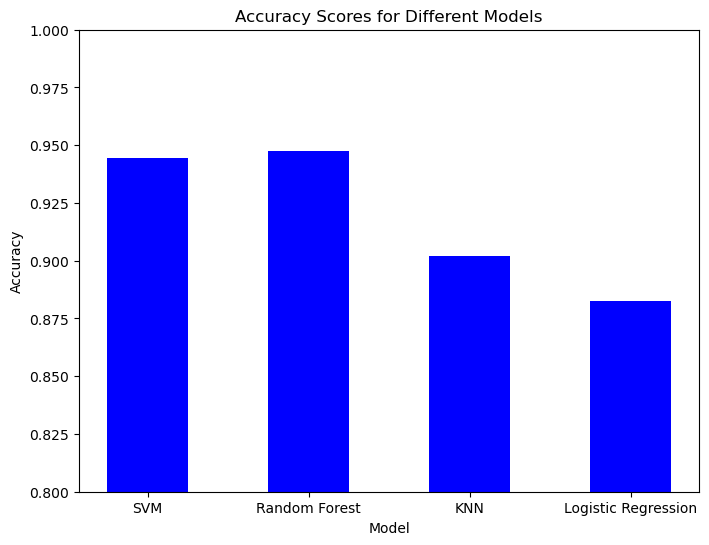

In [261]:
# Plot bar graph for accuracy scores
plt.figure(figsize=(8, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='blue',width=0.5)
plt.title('Accuracy Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.show()

In [262]:
# Calculate confusion matrices for each model
svm_cm = confusion_matrix(y_val, svm_val_pred)
rf_cm = confusion_matrix(y_val, rf_val_pred)
knn_cm = confusion_matrix(y_val, knn_val_pred)
lr_cm = confusion_matrix(y_val, lr_val_pred)


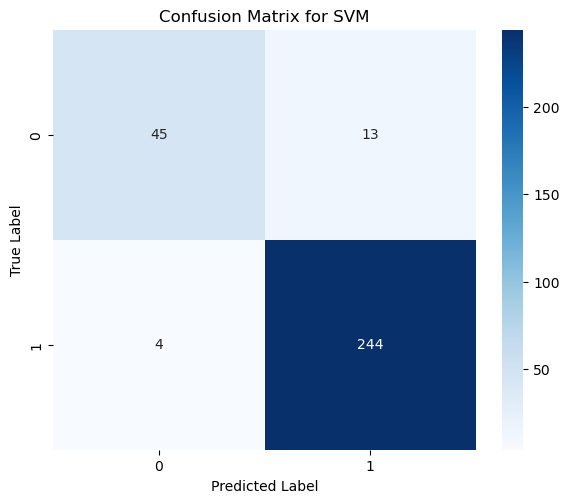

In [263]:
# Plot confusion matrices
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.heatmap(svm_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

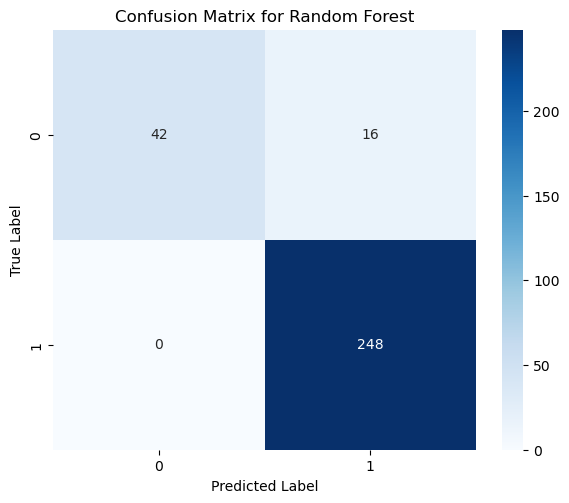

In [264]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 2)
sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

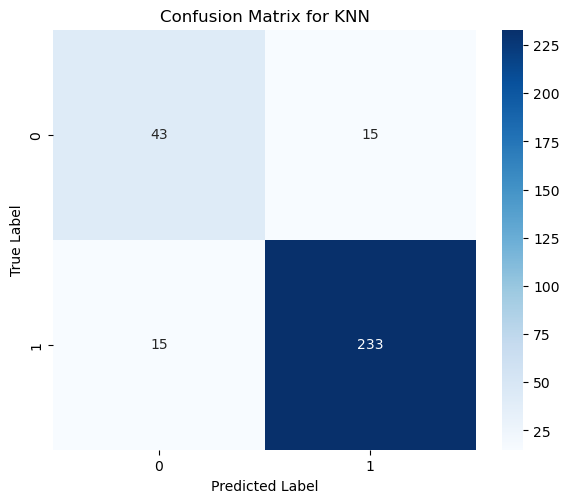

In [265]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 3)
sns.heatmap(knn_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.show()

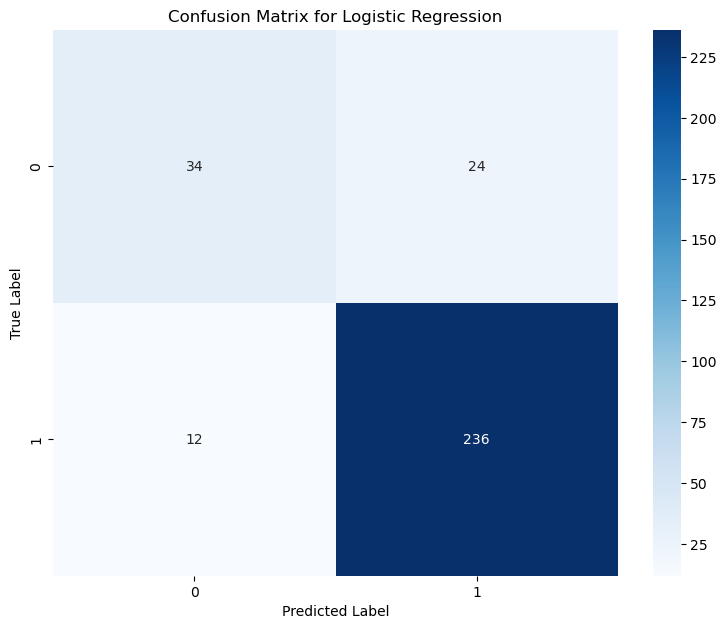

In [266]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 4)
sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

In [267]:
precision_scores = {
    'SVM': svm_scores['1']['precision'],
    'Random Forest': rf_scores['1']['precision'],
    'KNN': knn_scores['1']['precision'],
    'Logistic Regression': lr_scores['1']['precision']
}

In [268]:
recall_scores = {
    'SVM': svm_scores['1']['recall'],
    'Random Forest': rf_scores['1']['recall'],
    'KNN': knn_scores['1']['recall'],
    'Logistic Regression': lr_scores['1']['recall']
}

In [269]:
f1_scores = {
    'SVM': svm_scores['1']['f1-score'],
    'Random Forest': rf_scores['1']['f1-score'],
    'KNN': knn_scores['1']['f1-score'],
    'Logistic Regression': lr_scores['1']['f1-score']
}

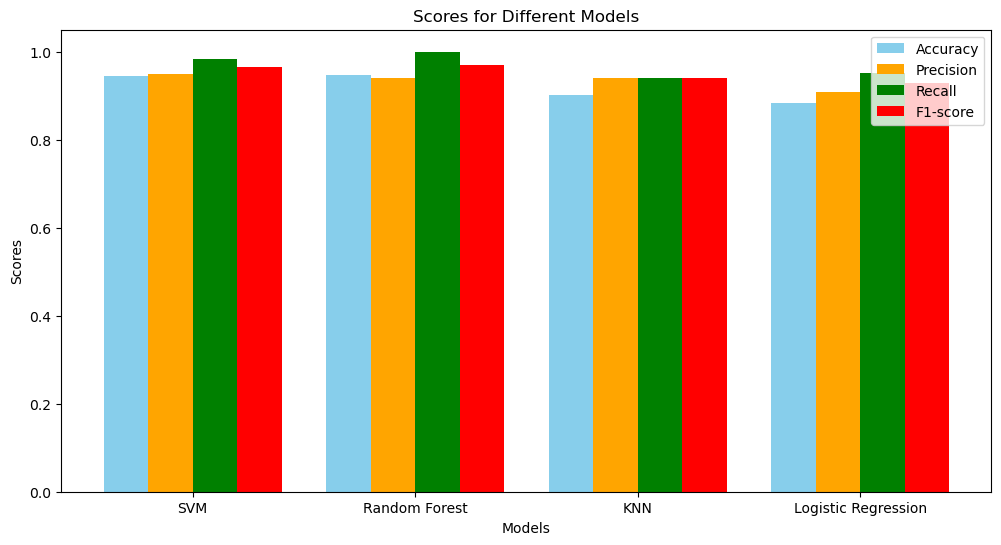

In [270]:
# Set up positions for the groups
models = list(accuracy_scores.keys())
ind = np.arange(len(models))
width = 0.2  # Width of the bars

# Plot grouped bar plots
plt.figure(figsize=(12, 6))

plt.bar(ind - width * 1.5, list(accuracy_scores.values()), width, label='Accuracy', color='skyblue')
plt.bar(ind - width * 0.5, list(precision_scores.values()), width, label='Precision', color='orange')
plt.bar(ind + width * 0.5, list(recall_scores.values()), width, label='Recall', color='green')
plt.bar(ind + width * 1.5, list(f1_scores.values()), width, label='F1-score', color='red')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Scores for Different Models')
plt.xticks(ind, models)
plt.legend()
plt.show()